In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
# from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay

In [39]:
health_df = pd.read_excel('Data_Analytics_Take_Home_HL.xlsx')
health_df.columns = health_df.columns.str.strip().str.lower().str.replace(" ", "_")

health_df.head()

,pageview_id,user_id,known_diagnosis,page_category,device_type,page_topic_description,session_start_time,asset_loaded_time,time_of_day,return_visitor,asset_shown,conversion
0,14afd810-bee0-4dde-984a-f36e5082cc13,00007820-89cb-4c1d-9940-eb270d605a35,,nauseaandvomiting,tablet,abdominal_pain,2023-08-26 09:18:09.785,2023-08-26 09:19:00.025,9,0,B,0
1,264d4634-8b76-4043-aa6a-768225dba92b,00012b55-514c-421e-9c76-3300abbc1134,,nauseaandvomiting,mobile,abdominal_pain,2023-08-13 18:47:03.635,2023-08-13 18:48:01.275,18,0,B,0
2,8759fa0b-3596-4306-b46c-aa2303490211,000157c1-b6a3-4c86-82c7-9ec1bda3799a,Ulcerative Colitis,nauseaandvomiting,desktop,food_poisoning,2023-08-28 11:19:24.177,2023-08-28 11:20:04.347,11,0,A,0
3,287d4980-19be-4654-bdd0-344ab656bcc3,00020400-efab-4b10-8812-2a0aaf774841,,nauseaandvomiting,tablet,food_poisoning,2023-08-12 00:23:40.564,2023-08-12 00:24:11.854,0,1,A,0
4,4c6e84c5-448d-4211-a307-a1e26a34f8ea,0002f737-0cda-48fb-91ed-533f3d0eab05,,nauseaandvomiting,mobile,food_poisoning,2023-08-07 11:29:20.634,2023-08-07 11:30:02.834,11,0,A,0


In [40]:
health_df["conversion_status"] = health_df['conversion'].map({0: 'Not Converted', 1: 'Converted'})
# health_df.head(5)

In [41]:
health_df['session_start_time'] = pd.to_datetime(health_df['session_start_time'])
health_df['asset_loaded_time'] = pd.to_datetime(health_df['asset_loaded_time'])
health_df['time_spent'] = (health_df['asset_loaded_time'] - health_df['session_start_time']).dt.total_seconds()
# health_df.head(5)

In [43]:
# Separating our fields into different types for easier processing
numeric = ['time_spent', 'time_of_day']
categorical = ['known_diagnosis', 'page_category', 'device_type', 'page_topic_description', 'asset_shown']
boolean = ['return_visitor']

columns_to_drop = [
    'pageview_id',
    'user_id',
    'session_start_time', 
    'asset_loaded_time',
    'conversion_status'
]

# Dropping columns that are not important:
health_df_processed = health_df.drop(columns=columns_to_drop)

# Apply get_dummies to categorical and boolean variables to feed into the model
health_df_encoded = pd.get_dummies(health_df_processed, columns=categorical + boolean, drop_first=True)

# Define X and y
X = health_df_encoded.drop('conversion', axis=1)
y = health_df_encoded['conversion']


# Split data into train sample and test sample
train_X, valid_X, train_y, valid_y = train_test_split(X, y, train_size=0.8, random_state=1)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Define parameter grid
param_grid = {
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_split': [2, 10, 20, 50],
    'classifier__min_impurity_decrease': [0, 0.0005, 0.001, 0.005]
}

# Perform Grid Search to get the best paraeters
gridSearch_auc = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
gridSearch_auc.fit(train_X, train_y)

print('\nInitial score: {:.2f}'.format(gridSearch_auc.best_score_))
print('Best parameters from param_grid: {}'.format(gridSearch_auc.best_params_))


Initial score: 0.80
Best parameters from param_grid: {'classifier__max_depth': 10, 'classifier__min_impurity_decrease': 0, 'classifier__min_samples_split': 50}


In [ ]:
# Get feature importances to actually have a ranking of features
feature_importances = gridSearch_auc.best_estimator_.named_steps['classifier'].feature_importances_

importance_df = pd.DataFrame({
    'Feature': train_X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                                              Feature  Importance
10                    page_category_ulcerativecolitis    0.178212
34                                   return_visitor_1    0.173033
1                                          time_spent    0.154959
9         page_category_otherinflammatoryboweldisease    0.144363
33                                      asset_shown_C    0.059564
23  page_topic_description_gastrointestinal_proced...    0.058473
27    page_topic_description_online_mental_healthcare    0.046671
19         page_topic_description_exercise_and_stress    0.045234
29   page_topic_description_probiotics_and_prebiotics    0.042414
32                                      asset_shown_B    0.031234
0                                         time_of_day    0.028901
8                page_category_otherdigestiveproblems    0.009641
7                     page_category_nauseaandvomiting    0.008398
5                           known_diagnosis_Migraine     0.002455
6         

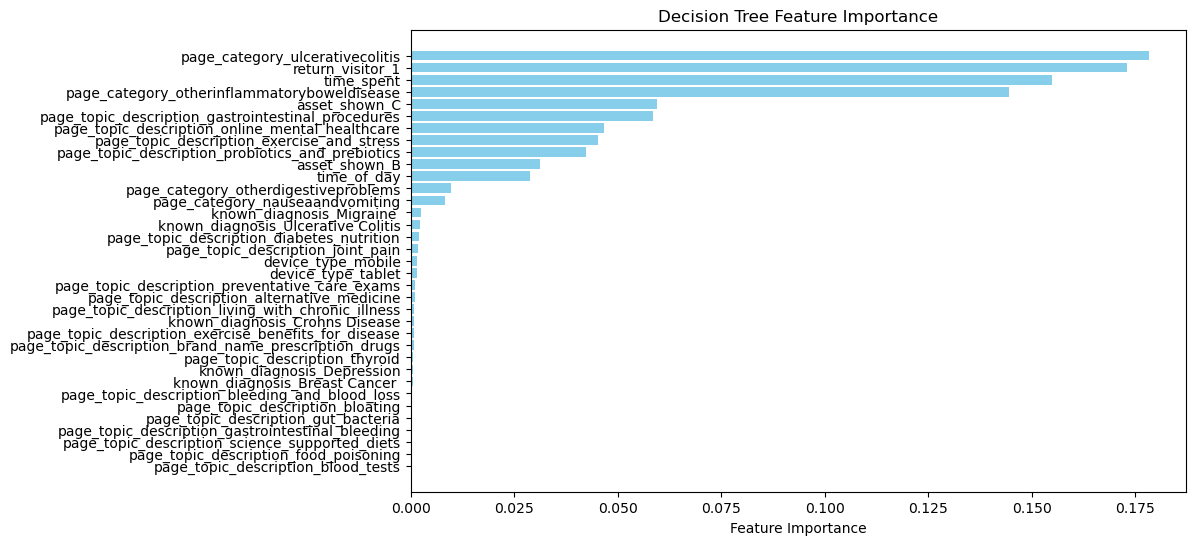

In [45]:
# Plot feature importance
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Feature Importance")
plt.title("Decision Tree Feature Importance")
plt.show()

In [46]:
# Relationship between Asset and other fields
dimensions = ['page_category', 'known_diagnosis', 'return_visitor']
for dim in dimensions:
    print(f"\nConversion Rate by {dim} and Asset:")
    pivot = pd.pivot_table(
        health_df,
        values='conversion',
        index=dim,
        columns='asset_shown',
        aggfunc='mean'
    )
    print(pivot)


Conversion Rate by page_category and Asset:
asset_shown                           A         B         C
page_category                                              
crohnsdisease                  0.443697  0.433333  0.546196
nauseaandvomiting              0.065689  0.015419  0.130186
otherdigestiveproblems         0.026274  0.000000  0.075524
otherinflammatoryboweldisease  0.179660  0.135946  0.260110
ulcerativecolitis              0.358491  0.297800  0.491803

Conversion Rate by known_diagnosis and Asset:
asset_shown                A         B         C
known_diagnosis                                 
                    0.108527  0.071052  0.170351
Breast Cancer       0.076525  0.031477  0.135823
Crohns Disease      0.158991  0.104701  0.149091
Depression          0.071150  0.037328  0.130699
Migraine            0.123469  0.085106  0.148789
Ulcerative Colitis  0.128622  0.090258  0.197561

Conversion Rate by return_visitor and Asset:
asset_shown            A         B         C
retur

In [47]:
# Create user segments based on key characteristics
health_df['user_segment'] = health_df.apply(
    lambda row: f"{row['page_topic_description']}_{row['page_category']}_{row['return_visitor']}", 
    axis=1
)

# Analyze segment performance by asset
segment_analysis = pd.pivot_table(
    health_df,
    values='conversion',
    index='user_segment',
    columns='asset_shown',
    aggfunc=['mean', 'count'],
    margins=True
)

print("\nSegment Performance by Asset:")
print(segment_analysis.head(10))

# Identify best performing asset for each segment
best_asset_by_segment = segment_analysis['mean'].idxmax(axis=1)
print("\nRecommended Asset by Segment:")
print(best_asset_by_segment)


Segment Performance by Asset:
                                                 mean                      \
asset_shown                                         A         B         C   
user_segment                                                                
abdominal_pain_nauseaandvomiting_0           0.043762  0.010984  0.100690   
abdominal_pain_nauseaandvomiting_1           0.162371  0.032967  0.216117   
alternative_medicine_ulcerativecolitis_0     0.289738  0.269565  0.387755   
alternative_medicine_ulcerativecolitis_1     0.569106  0.437500  0.808511   
bleeding_and_blood_loss_nauseaandvomiting_0  0.051566  0.010688  0.107809   
bleeding_and_blood_loss_nauseaandvomiting_1  0.184783  0.035616  0.301639   
bloating_otherdigestiveproblems_0            0.017423  0.000000  0.051789   
bloating_otherdigestiveproblems_1            0.060137  0.000000  0.142857   
blood_tests_otherdigestiveproblems_0         0.020690  0.000000  0.068998   
blood_tests_otherdigestiveproblems_1         